In [7]:
pip install scikit-survival lifelines statsmodels

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.5/847.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 6.2 MB/s eta 0:00:00a 0:00:01
  Created wheel for ecos: filename=ecos-2.0.14-cp312-cp312-macosx_11_0_arm64.whl size=72521 sha256=df6db73109eb3b924aeefdf90e072ffef66d28e8184ad94aa27c1d3bcd01a9c5
  Stored in directory: /Users/veronicacruz/Library/Caches/pip/wheels/b8/d9/1e/77a592ed2465d4dde07f30f787f9d43834c0fd7a1467371694
Successfully built ecos
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.1
    Uninstalling scikit-learn-1.5.1:
      Successfully uninstalled scikit-learn-1.5.1
Note: you may need to restart the kernel to use updated packages.


### Import Libraries 

In [ ]:
#====================================================#
#           Data Manipulation and Plotting           #
#====================================================#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

#====================================================#
#       Kaplan-Meier, Cox and RSF and  Analysis      #
#====================================================#

from lifelines import KaplanMeierFitter, CoxPHFitter
from sksurv.ensemble import RandomSurvivalForest

#====================================================#
#                    Evaluation                      #
#====================================================#
from lifelines.statistics import logrank_test
from sklearn.inspection import permutation_importance

### Load Dataset and Additional Prep (Feature Engineering)

In [ ]:
#===========LOAD & SELECT DATA===========#
data = pd.read_excel('../Data/RADCURE_Clinical_v04_20241219.xlsx')

extract_data = data[['Length FU', 'Status', 'Tx Modality','Stage']].rename(
    columns ={
        'Length FU': 'followup_years',
        'Tx Modality':'treatment_type', 
        'Stage':'cancer_stage'
    }
)
#===========PREPARE VARIABLES===========#
clean_data = extract_data.dropna(subset=['followup_years','Status', 'cancer_stage']) #remove rows where data is missing for follow-up, vital status, cancer stage
clean_data['time_months']= clean_data['followup_years'] * 12.0 #convert follow up time from years to months 
clean_data['death_flag']= data['Status'] == 'Dead' #make event flag for vital status to dead = true , alive = false
clean_data['treatment_type'] = clean_data['treatment_type'].str.strip()

print(clean_data['cancer_stage'].unique())
print(clean_data.head())
print(clean_data['treatment_type'].value_counts(dropna=False))

['IVB' 'I' 'IVA' 'III' 'II' 'IV' 0 'IIIC' 'IB' 'X' 'IIA' 'IIIA' 'IVC'
 'IIB']
   followup_years Status treatment_type cancer_stage  time_months  death_flag
0        1.317808   Dead       RT alone          IVB    15.813699        True
1        1.520548   Dead       RT alone            I    18.246575        True
2        2.126027  Alive       RT alone          IVA    25.512329       False
3        5.791781  Alive       RT alone          IVA    69.501370       False
4        9.512329  Alive       RT alone          IVB   114.147945       False
treatment_type
RT alone           1840
ChemoRT            1404
RT + EGFRI           72
Postop RT alone       3
Name: count, dtype: int64


/var/folders/4z/1rp4gvm502j0k5_bz4l6mlfr0000gn/T/ipykernel_3386/650868368.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['time_months']= clean_data['followup_years'] * 12.0 #convert follow up time from years to months
/var/folders/4z/1rp4gvm502j0k5_bz4l6mlfr0000gn/T/ipykernel_3386/650868368.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['death_flag']= data['Status'] == 'Dead' #make event flag for vital status to dead = true , alive = false
/var/folders/4z/1rp4gvm502j0k5_bz4

## Build and Evaluate Models

### Kaplan-Meier Analysis 

death_flag
False    1141
True      699
Name: count, dtype: int64
death_flag
False    1090
True      314
Name: count, dtype: int64
death_flag
False    37
True     35
Name: count, dtype: int64
death_flag
True     2
False    1
Name: count, dtype: int64


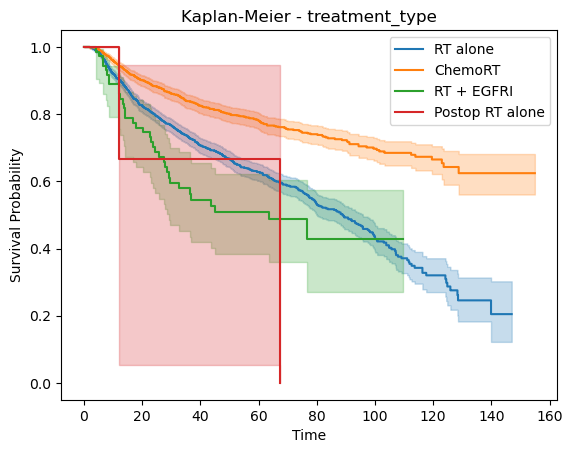

death_flag
True     158
False    151
Name: count, dtype: int64
death_flag
False    273
True      79
Name: count, dtype: int64
death_flag
False    1087
True      494
Name: count, dtype: int64
death_flag
False    424
True     181
Name: count, dtype: int64
death_flag
False    288
True     112
Name: count, dtype: int64
death_flag
True     7
False    5
Name: count, dtype: int64
death_flag
False    34
True     10
Name: count, dtype: int64
death_flag
True    2
Name: count, dtype: int64
death_flag
False    1
Name: count, dtype: int64
death_flag
True     4
False    2
Name: count, dtype: int64
death_flag
False    2
Name: count, dtype: int64
death_flag
True    2
Name: count, dtype: int64
death_flag
False    2
Name: count, dtype: int64
death_flag
True    1
Name: count, dtype: int64


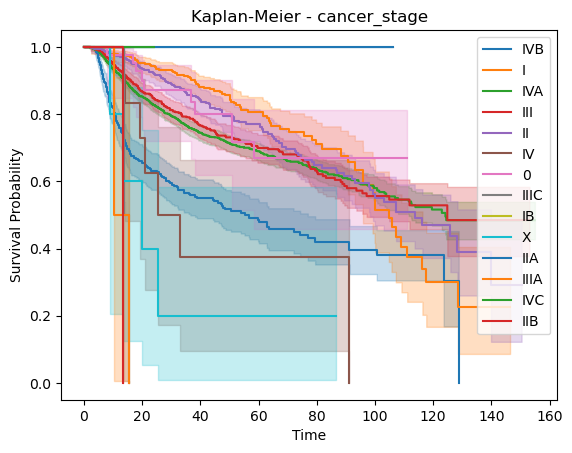

In [40]:
#------- Kaplan-Meier Survival Curves for 2 groups (Treatment, age, tumor stage)
def plot_kaplan_meier(data, colName):
    # Fit the Kaplan-Meier estimator
    kmf = KaplanMeierFitter()
    for col in data[colName].unique():
        subData = data.loc[data[colName] == col]
        print(subData['death_flag'].value_counts())
        kmf.fit(subData['time_months'], event_observed=subData['death_flag'], label = col)

        # Plot the Kaplan-Meier curve
        kmf.plot_survival_function()
    plt.title(f'Kaplan-Meier - {colName}')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.show()

#plot for group  1: Treatment type  
plot_kaplan_meier(clean_data, 'treatment_type')

#plot for group  2: Cancer Stage 
plot_kaplan_meier(clean_data, 'cancer_stage')
#Log rank test for group 1

#log rank test for group 2

### Cox Propirtional Hazards Regression 

In [ ]:
#----- Cox regression with at lead 3 covariates 

#validate proptional hazard Assumptions 

### Random Survival Forests (RSF)

In [ ]:
## build random survival forest model 

# preform vairabl eimporance analysis to find predicitve factors

## RSF vs Cox Comparison

In [ ]:
## compare RSF models concordance index (C-index) with Cox regression 